In [267]:
import numpy as np
import math
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from netCDF4 import Dataset

from sklearn.preprocessing import MinMaxScaler


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

import pickle
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [6]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [7]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

In [234]:
def min_MSE_finder(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        result.append(mean_squared_error(y_pred, y_test))
    return(result,link)

In [326]:
N = ET_gamma.shape[1]

In [413]:
ET_gamma = np.load("Brazil_gamma_3.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))


name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_brazil_3")

q_matrix = np.load("q_matrix_brazil_3.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 55 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.480
        (SST_50 -5): pval = 0.00031 | val = 0.206
        (SST_62 -9): pval = 0.00283 | val = 0.171
        (SST_13 -4): pval = 0.00416 | val = -0.165
        (SST_8 -5): pval = 0.00572 | val = -0.158
        (SST_31 -5): pval = 0.00550 | val = 0.158
        (SST_48 -5): pval = 0.00666 | val = -0.155
        (SST_7 -9): pval = 0.00817 | val = 0.152
        (SST_17 -10): pval = 0.00890 | val = 0.151
        (SST_64 -7): pval = 0.00981 | val = 0.149
        (SST_11 -12): pval = 0.00954 | val = 0.148
        (SST_50 -11): pval = 0.01129 | val = 0.146
        (SST_30 -5): pval = 0.01176 | val = 0.144
        (SST_32 -9): pval = 0.01214 | val = 0.144
        (SST_46 -5): pval = 0.01333 | val = -0.140
        (SST_22 -7): pval = 0.01421 | val = 0.140
        (SST_51 -7): pval = 0.01541 | val = -0.138
        (SST_28 -3): pval = 0.01413 | val = 0.138
        (S

In [414]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.480

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.551

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.593

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.603

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.520

    Variable SST_4 has 1 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.486

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.552

    Variable SST_6 has 1 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.579

    Variable SST_7 has 1 link(s):
        (SST_7 -1): pval = 0.00000 | qval = 0.00000 | val = 0.465

    Variable SST_8 has 1 link(s):
       

In [415]:
pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']
alpha_level = 0.05

link_dict = dict()
for j in range(77):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)


In [318]:
#link_dict[0].remove((9, -5))

In [416]:
link = np.array(link_dict[0])

link = link[1:,: ]

In [281]:
#np.random.shuffle(link[1:,:])

In [417]:
n_estimators=100
max_depth=5
tau = -1

In [418]:
#np.random.shuffle(link[1:,:])

result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)

overall_min_MSE = []
overall_min_MSE.append(min(result))

Text(0, 0.5, 'MSE')

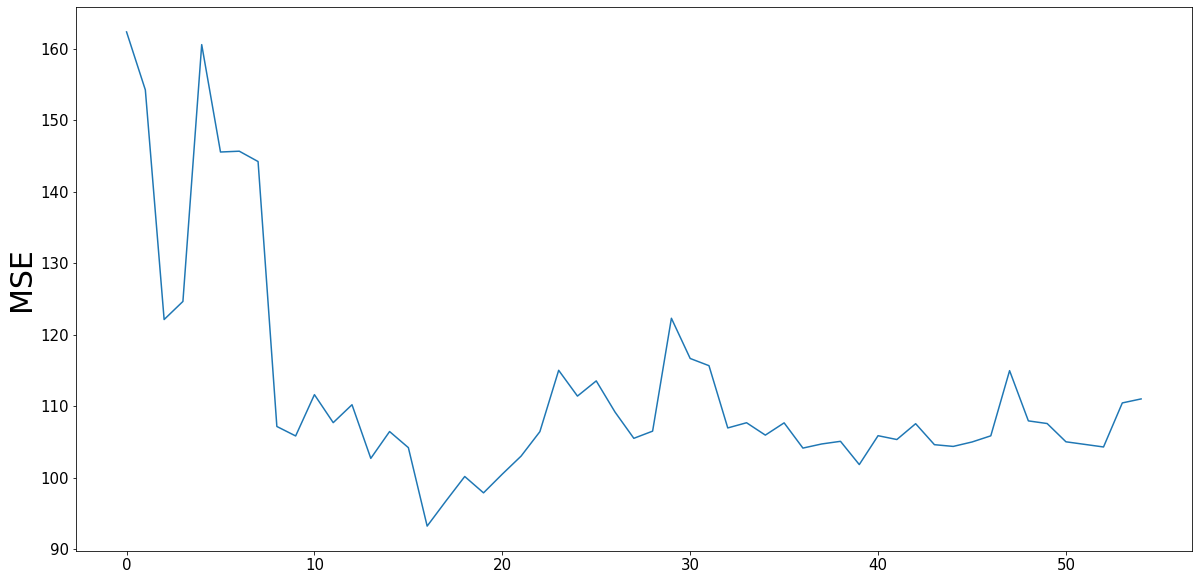

In [419]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [420]:
min(result)

93.25009207761101

In [421]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link_list.append(link)
    link = link[I,:]
    result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0 

In [422]:
result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)

In [423]:
overall_min_MSE

[93.25009207761101,
 89.25288455200875,
 90.38898262023457,
 92.09269630151967,
 92.09269630151967,
 92.09269630151967]

Text(0, 0.5, 'MSE')

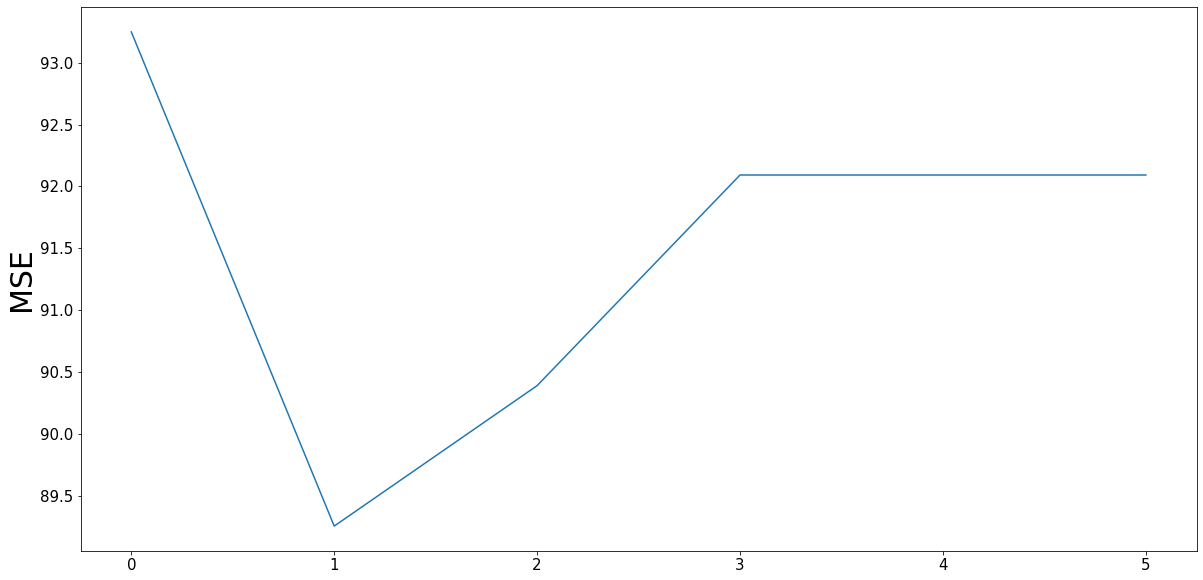

In [424]:
plt.plot(overall_min_MSE)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

Text(0, 0.5, 'MSE')

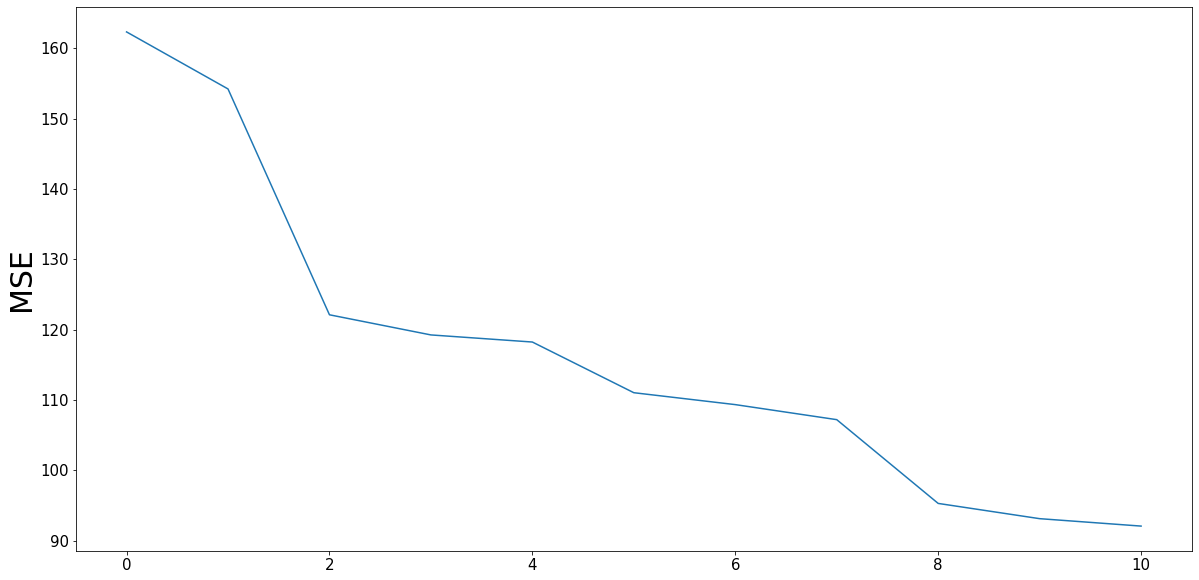

In [425]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [427]:
link_list[1]

array([[ 51,  -5],
       [ 63,  -9],
       [ 32,  -5],
       [  8,  -9],
       [ 18, -10],
       [ 65,  -7],
       [ 51, -11],
       [ 33,  -9],
       [ 23,  -7],
       [ 52,  -7],
       [ 74,  -4],
       [  9,  -2],
       [ 37, -12],
       [ 76,  -2],
       [ 39,  -1],
       [ 40,  -3],
       [ 36,  -9],
       [ 22, -11],
       [ 28,  -9],
       [ 21,  -1],
       [ 54,  -1],
       [ 43, -10],
       [ 71,  -5],
       [ 56,  -1],
       [ 36, -12],
       [ 13,  -7],
       [  8,  -2],
       [ 32,  -9]])

In [182]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
#I = np.insert(I, 0, True)
#link = np.array(link_dict[0])[I,:]
link = link[I,:]

In [203]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link = link[I,:]
    result, link = min_MSE_finder(count, result_sst, link, -6)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0 

In [184]:
result, link = min_MSE_finder(count, result_sst, link, -6)

In [208]:
link

array([[ 63,  -9],
       [ 18, -10],
       [ 65,  -7],
       [ 33,  -9],
       [  0, -12],
       [ 36,  -9],
       [  5,  -6]])

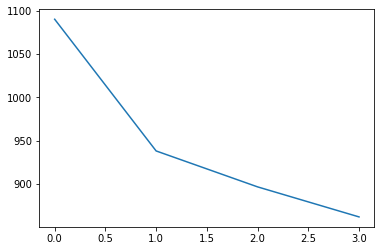

In [204]:
plt.plot(overall_min_MSE)

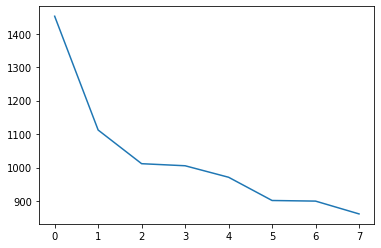

In [206]:
plt.plot(result)

In [142]:
result =[]

df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
result.append(mean_squared_error(y_pred, y_test))

for z in range(len(link)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(0,z+1):
            if link[k,0] != 0:
                df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
            else:
                df[str(link[k,0])] = count
                df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))

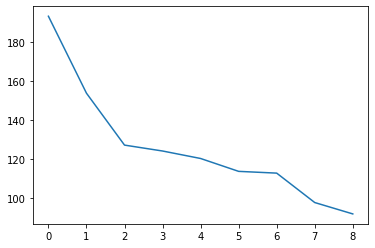

In [143]:
plt.plot(result)

In [144]:
min(result)

91.66595830299089

In [145]:
link

array([[ 51,  -5],
       [ 63,  -9],
       [ 32,  -5],
       [ 18, -10],
       [ 65,  -7],
       [ 33,  -9],
       [ 52,  -7],
       [ 25, -10]])

In [330]:
important_features_dict = {}
for x,i in enumerate(model.feature_importances_):
    important_features_dict[x]=i
    
important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

In [331]:
Index = np.array(important_features_list) < 15

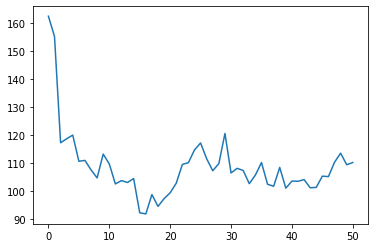

In [281]:
df = pd.DataFrame({"drought":count, "drought1":count, "sst50":result_sst[:,50]})

In [284]:
df

drought  drought1     sst50
0         16       NaN  8.011673
1          2      16.0 -1.274551
2         14       2.0  4.541126
3         15      14.0 -5.566275
4          4      15.0 -6.938711
..       ...       ...       ...
463       24      38.0  4.659546
464       24      24.0  2.458419
465       36      24.0 -1.022723
466       48      36.0  4.166445
467       67      48.0  6.792086

[468 rows x 3 columns]

In [109]:
df=(df-df.mean())/df.std()

In [69]:
result=[]
for i in range(1,len(link_dict[0])):
    df = pd.DataFrame({"drought":count, "sst":result_sst[:,link_dict[0][i][0]-1]})
    granger = grangercausalitytests(df,maxlag=24,verbose=False)
    j = 1
    while granger[j][0]['ssr_ftest'][1] >= 0.05:
        j+=1
        if j == 25:break
    result.append(j)

In [8]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.480

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.551

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.593

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.603

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.520

    Variable SST_4 has 1 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.486

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.552

    Variable SST_6 has 1 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.579

    Variable SST_7 has 1 link(s):
        (SST_7 -1): pval = 0.00000 | qval = 0.00000 | val = 0.465

    Variable SST_8 has 1 link(s):
       

# California

In [337]:
ET_gamma = np.load("Cal_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))


name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_cal")

q_matrix = np.load("q_matrix_cal.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 53 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.444
        (SST_40 -7): pval = 0.00001 | val = -0.250
        (n_extremes -12): pval = 0.00056 | val = -0.199
        (SST_65 -10): pval = 0.00189 | val = 0.181
        (SST_68 -3): pval = 0.00383 | val = 0.167
        (SST_17 -10): pval = 0.00540 | val = 0.164
        (SST_57 -1): pval = 0.00488 | val = -0.162
        (SST_72 -7): pval = 0.00538 | val = -0.162
        (SST_0 -11): pval = 0.00441 | val = -0.160
        (SST_47 -11): pval = 0.00596 | val = -0.159
        (SST_22 -6): pval = 0.00689 | val = 0.156
        (SST_49 -3): pval = 0.00646 | val = 0.156
        (SST_72 -5): pval = 0.00727 | val = 0.155
        (SST_19 -5): pval = 0.00798 | val = 0.152
        (SST_18 -3): pval = 0.00825 | val = -0.152
        (SST_51 -8): pval = 0.01145 | val = 0.147
        (SST_7 -12): pval = 0.01198 | val = 0.145
        (SST_11 -4): pval = 0.01182 | val = 0.144
 

In [381]:
pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']
alpha_level = 0.05

link_dict = dict()
for j in range(77):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)

In [398]:
link = np.array(link_dict[0])

link = link[1:,: ]

In [399]:
link

array([[ 41,  -7],
       [  0, -12],
       [ 66, -10],
       [ 69,  -3],
       [ 18, -10],
       [ 58,  -1],
       [ 73,  -7],
       [  1, -11],
       [ 48, -11],
       [ 23,  -6],
       [ 50,  -3],
       [ 73,  -5],
       [ 20,  -5],
       [ 19,  -3],
       [ 52,  -8],
       [  8, -12],
       [ 12,  -4],
       [ 33,  -8],
       [ 11,  -2],
       [  4,  -1],
       [  3, -10],
       [ 50,  -4],
       [ 26,  -5],
       [ 41,  -9],
       [ 15,  -5],
       [ 14,  -8],
       [ 25, -12],
       [ 75,  -2],
       [ 40,  -2],
       [ 15,  -1],
       [ 75,  -7],
       [ 34, -12],
       [ 64, -12],
       [ 76,  -4],
       [ 34,  -4],
       [ 50,  -8],
       [  4,  -8],
       [ 30,  -4],
       [ 33,  -5],
       [ 55,  -7],
       [ 37,  -3],
       [ 35,  -8],
       [ 28, -11],
       [ 16,  -1],
       [  3, -11],
       [ 30,  -5],
       [ 73,  -6],
       [ 21,  -7],
       [ 18,  -8],
       [ 56,  -9],
       [ 49,  -8],
       [ 69,  -7]])

In [401]:
n_estimators=100
max_depth=10
tau = -6

In [402]:
link[link[:,1] <= tau]

array([[ 41,  -7],
       [  0, -12],
       [ 66, -10],
       [ 18, -10],
       [ 73,  -7],
       [  1, -11],
       [ 48, -11],
       [ 23,  -6],
       [ 52,  -8],
       [  8, -12],
       [ 33,  -8],
       [  3, -10],
       [ 41,  -9],
       [ 14,  -8],
       [ 25, -12],
       [ 75,  -7],
       [ 34, -12],
       [ 64, -12],
       [ 50,  -8],
       [  4,  -8],
       [ 55,  -7],
       [ 35,  -8],
       [ 28, -11],
       [  3, -11],
       [ 73,  -6],
       [ 21,  -7],
       [ 18,  -8],
       [ 56,  -9],
       [ 49,  -8],
       [ 69,  -7]])

In [403]:
#np.random.shuffle(link[1:,:])

result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)

overall_min_MSE = []
overall_min_MSE.append(min(result))

Text(0, 0.5, 'MSE')

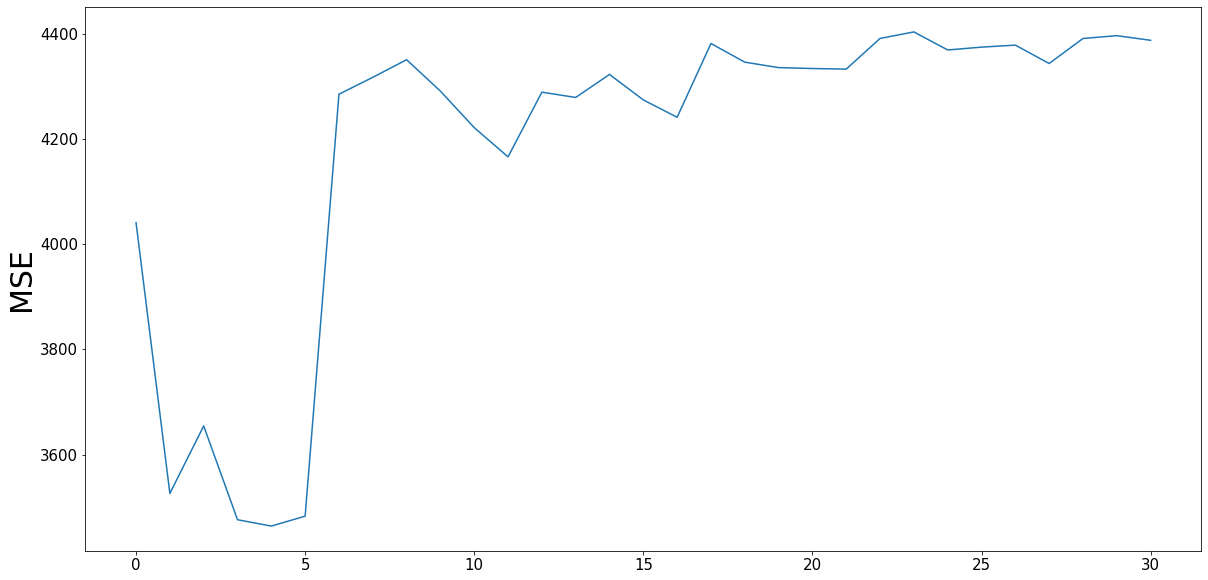

In [404]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [405]:
min(result)

3463.9020446224276

In [406]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link_list.append(link)
    link = link[I,:]
    result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0

In [407]:
result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)

Text(0, 0.5, 'MSE')

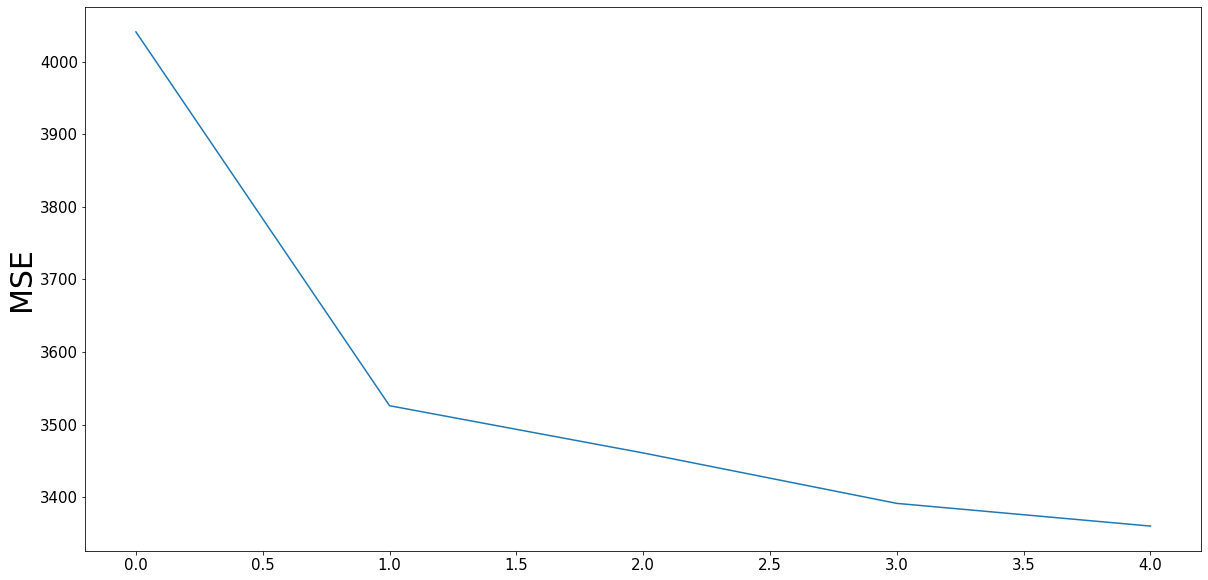

In [408]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [409]:
min(result)

3360.173885467148

In [410]:
overall_min_MSE

[3463.9020446224276,
 3460.9030158451287,
 3278.964546875602,
 3360.173885467148,
 3360.173885467148]

Text(0, 0.5, 'MSE')

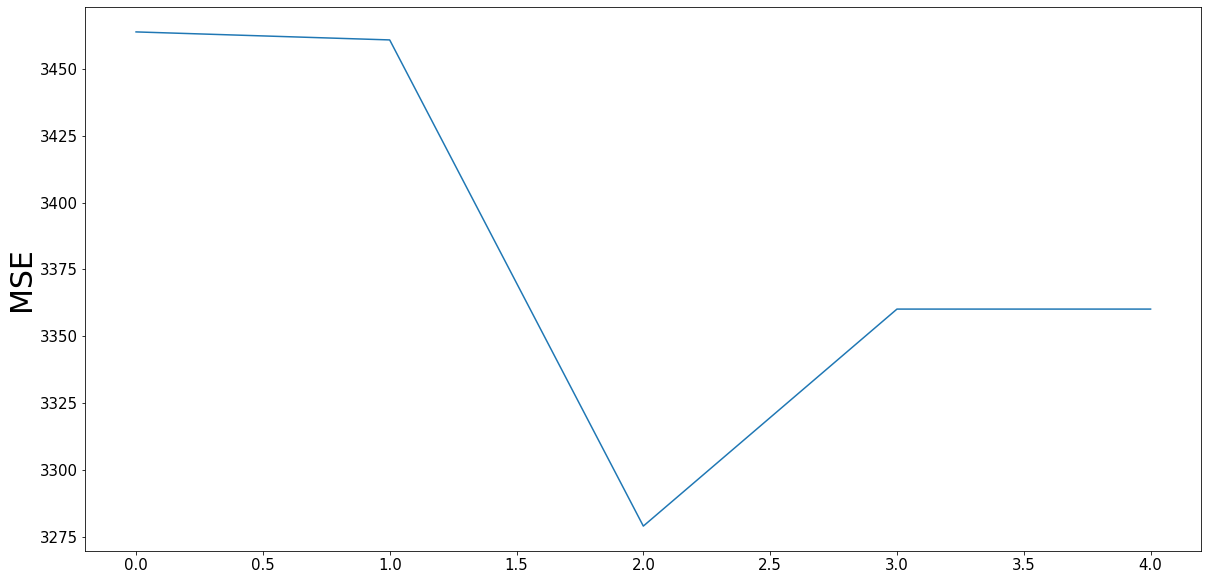

In [411]:
plt.plot(overall_min_MSE)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [412]:
link_list[2]

array([[ 41,  -7],
       [ 66, -10],
       [ 33,  -8],
       [ 75,  -7],
       [ 50,  -8],
       [ 55,  -7],
       [  3, -11]])

In [261]:
link = np.array(link_dict[0])

In [244]:
np.random.shuffle(link[1:,:])

In [262]:
result =[]
tau = -6
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
result.append(mean_squared_error(y_pred, y_test))

for z in range(1,len(link)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(1,z+1):
        if link[k,1] <= tau:
            if link[k,0] != 0 and link[k,1] >= tau:
                df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
            else:
                df[str(link[k,0])] = count
                df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))

In [246]:
result

[4040.766630946538,
 3999.845715788692,
 3983.8372232295133,
 3725.3718545579395,
 3725.3718545579395,
 3725.3718545579395,
 3725.3718545579395,
 3725.3718545579395,
 3725.3718545579395,
 3833.655487009778,
 3783.2049167837235,
 3783.2049167837235,
 3802.2983003905865,
 3802.2983003905865,
 3802.2983003905865,
 3799.689094015101,
 3799.689094015101,
 3792.3539662133694,
 3804.2041337619144,
 3804.2041337619144,
 3796.4283334278375,
 3800.1885475546865,
 3835.7882142216367,
 3835.7762962585452,
 3835.7762962585452,
 3719.920441439884,
 3708.9141134700176,
 3708.9141134700176,
 3719.706205471332,
 3703.951118664982,
 3703.951118664982,
 3703.951118664982,
 3703.951118664982,
 3744.7522991408414,
 3744.7522991408414,
 3758.024271118671,
 3750.849629023508,
 3759.6756754510843,
 3733.6075109112207,
 3743.643888309989,
 3750.4592761936797,
 3741.1523603407086,
 3726.808428374815,
 3714.537687185424,
 3714.537687185424,
 3714.537687185424,
 3708.8742664938845,
 3708.8742664938845,
 3711.8269

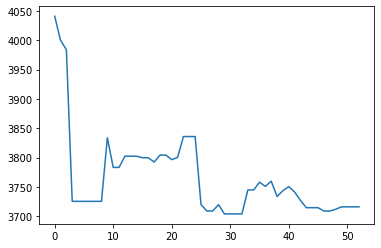

In [247]:
plt.plot(result)

In [257]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]

I = np.array(diff) < 0 
I = np.insert(I, 0, True)

#link = np.array(link_dict[0])[I,:]
link = link[I,:]

In [258]:
result =[]
tau = -6
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
result.append(mean_squared_error(y_pred, y_test))

for z in range(1,len(link)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(1,z+1):
        if link[k,0] != 0:
            df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
            df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
        else:
            df[str(link[k,0])] = count
            df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))



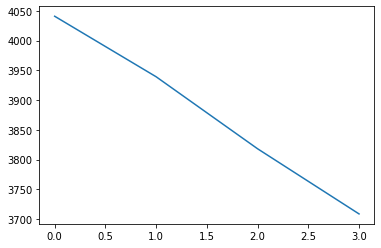

In [259]:
plt.plot(result)

In [260]:
link

array([[  0,  -1],
       [ 25, -12],
       [ 66, -10],
       [  0, -12]])

In [202]:
link

array([[  0,  -1],
       [ 30,  -4],
       [ 66, -10],
       [ 41,  -7],
       [ 69,  -7],
       [ 50,  -8],
       [ 35,  -8],
       [ 33,  -8],
       [  0, -12]])

array([[  0,  -1],
       [ 41,  -7],
       [ 18, -10]])

In [142]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 2 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.444
        (SST_40 -7): pval = 0.00001 | qval = 0.01772 | val = -0.250

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.544

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.612

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.608

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.537

    Variable SST_4 has 1 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.481

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.549

    Variable SST_6 has 1 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.586

    Variable SST_7 has 1 link(s):
        (SST_7 -1): pval = 0.00000 | qva

In [19]:
ET_gamma = np.load("Brazil_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))


name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_brazil")

q_matrix = np.load("q_matrix_brazil.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 53 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.383
        (SST_70 -3): pval = 0.00120 | val = 0.185
        (SST_63 -4): pval = 0.00160 | val = 0.179
        (SST_64 -7): pval = 0.00337 | val = -0.167
        (n_extremes -2): pval = 0.00272 | val = 0.167
        (SST_50 -5): pval = 0.00361 | val = 0.166
        (SST_35 -8): pval = 0.00514 | val = 0.159
        (SST_42 -7): pval = 0.00723 | val = -0.155
        (SST_23 -12): pval = 0.00661 | val = 0.154
        (SST_62 -6): pval = 0.00885 | val = -0.149
        (n_extremes -12): pval = 0.00814 | val = -0.149
        (SST_70 -8): pval = 0.01007 | val = 0.148
        (SST_37 -9): pval = 0.01043 | val = 0.147
        (SST_36 -5): pval = 0.01133 | val = 0.144
        (SST_17 -10): pval = 0.01279 | val = 0.144
        (SST_45 -5): pval = 0.01524 | val = -0.141
        (SST_46 -5): pval = 0.01337 | val = -0.141
        (SST_60 -1): pval = 0.01326 | val = 0.141

In [20]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.383

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.536

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.607

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.593

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.515

    Variable SST_4 has 2 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.463
        (SST_48 -9): pval = 0.00002 | qval = 0.02545 | val = -0.242

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.558

    Variable SST_6 has 2 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.572
        (SST_55 -9): pval = 0.00002 | qval = 0.02919 | val = 0.239

    Var

In [9]:
ET_gamma = np.load("Aus_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))


name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_aus")

q_matrix = np.load("q_matrix_aus.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 44 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.508
        (SST_38 -4): pval = 0.00279 | val = -0.167
        (SST_25 -2): pval = 0.00348 | val = -0.164
        (SST_63 -12): pval = 0.00374 | val = -0.163
        (SST_50 -2): pval = 0.00473 | val = -0.159
        (SST_39 -6): pval = 0.00521 | val = -0.158
        (SST_5 -5): pval = 0.00638 | val = 0.152
        (SST_73 -7): pval = 0.00794 | val = 0.148
        (SST_11 -4): pval = 0.00832 | val = 0.147
        (SST_38 -9): pval = 0.01005 | val = -0.143
        (n_extremes -12): pval = 0.00934 | val = -0.142
        (SST_50 -7): pval = 0.01294 | val = 0.140
        (SST_57 -9): pval = 0.01264 | val = 0.139
        (SST_36 -11): pval = 0.01346 | val = -0.139
        (SST_45 -8): pval = 0.01543 | val = -0.139
        (SST_28 -6): pval = 0.01476 | val = 0.136
        (SST_70 -9): pval = 0.01609 | val = -0.136
        (SST_22 -3): pval = 0.01656 | val = 0.134


In [12]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.508

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.531

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.599

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.607

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.529

    Variable SST_4 has 1 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.491

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.511

    Variable SST_6 has 1 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.546

    Variable SST_7 has 1 link(s):
        (SST_7 -1): pval = 0.00000 | qval = 0.00000 | val = 0.477

    Variable SST_8 has 1 link(s):
       

In [5]:
name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc","../../nc/pres.mon.mean.nc","../../nc/air.mon.mean.nc","../../nc/sst.mnmean.nc"]
code = ["precip", "pres", "air", "sst"]
missing = [-9.96921e+36, -9.96921e+36, -9.96921e+36,-9.96921e+36]
n_components = [87, 64, 82, 76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]
               
    data = pd.DataFrame(result)

    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(scaled_data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)
    
pres_name  = []
for i in range(n_components[1]):
    pres_name.append("PRES_%d"%i)
    
sat_name  = []
for i in range(n_components[2]):
    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[3]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name + pres_name + sat_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))
result_precip = np.array(df_cluster[0])
result_pres = np.array(df_cluster[1])
result_sat = np.array(df_cluster[2])
result_sst = np.array(df_cluster[3])


result = np.concatenate((result_extremes,result_precip, result_pres, result_sat, result_sst), axis=1)
result = np.array(result)

In [8]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()

In [9]:
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [7]:
#results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)

In [5]:
results = load_obj("results")

In [6]:
q_matrix = np.load("q_matrix.npy")

In [10]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 42 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.587
        (PRECIP_1 -1): pval = 0.00023 | val = 0.196
        (SAT_70 -1): pval = 0.00055 | val = 0.188
        (PRECIP_39 -1): pval = 0.00068 | val = 0.185
        (SAT_62 -1): pval = 0.00182 | val = -0.172
        (PRECIP_5 -1): pval = 0.00197 | val = 0.171
        (SST_60 -2): pval = 0.00210 | val = -0.168
        (PRECIP_49 -2): pval = 0.00280 | val = -0.165
        (PRES_29 -1): pval = 0.00375 | val = 0.158
        (PRECIP_13 -1): pval = 0.00508 | val = -0.155
        (PRES_32 -2): pval = 0.00491 | val = -0.154
        (PRES_32 -1): pval = 0.00492 | val = 0.154
        (PRECIP_11 -1): pval = 0.01009 | val = 0.142
        (PRECIP_78 -2): pval = 0.01073 | val = -0.142
        (SST_29 -1): pval = 0.01012 | val = -0.141
        (PRECIP_43 -2): pval = 0.01330 | val = -0.139
        (SST_41 -2): pval = 0.01254 | val = 0.138
        (PRES_46 -1): pval = 0.01

In [11]:
#q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.587

    Variable PRECIP_0 has 1 link(s):
        (SAT_7 -1): pval = 0.00002 | qval = 0.02883 | val = -0.236

    Variable PRECIP_1 has 0 link(s):

    Variable PRECIP_2 has 0 link(s):

    Variable PRECIP_3 has 0 link(s):

    Variable PRECIP_4 has 0 link(s):

    Variable PRECIP_5 has 0 link(s):

    Variable PRECIP_6 has 0 link(s):

    Variable PRECIP_7 has 0 link(s):

    Variable PRECIP_8 has 0 link(s):

    Variable PRECIP_9 has 0 link(s):

    Variable PRECIP_10 has 1 link(s):
        (PRECIP_60 -1): pval = 0.00001 | qval = 0.01316 | val = -0.242

    Variable PRECIP_11 has 0 link(s):

    Variable PRECIP_12 has 0 link(s):

    Variable PRECIP_13 has 0 link(s):

    Variable PRECIP_14 has 0 link(s):

    Variable PRECIP_15 has 0 link(s):

    Variable PRECIP_16 has 0 link(s):

    Variable PRECIP_17 has 1 link(s):
        (PRECIP_51 -

In [12]:
ET_gamma = np.load("Cal_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))


In [13]:
name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


In [14]:
result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [15]:
results = load_obj("results_cal")

q_matrix = np.load("q_matrix_cal.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 53 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.444
        (SST_40 -7): pval = 0.00001 | val = -0.250
        (n_extremes -12): pval = 0.00056 | val = -0.199
        (SST_65 -10): pval = 0.00189 | val = 0.181
        (SST_68 -3): pval = 0.00383 | val = 0.167
        (SST_17 -10): pval = 0.00540 | val = 0.164
        (SST_57 -1): pval = 0.00488 | val = -0.162
        (SST_72 -7): pval = 0.00538 | val = -0.162
        (SST_0 -11): pval = 0.00441 | val = -0.160
        (SST_47 -11): pval = 0.00596 | val = -0.159
        (SST_22 -6): pval = 0.00689 | val = 0.156
        (SST_49 -3): pval = 0.00646 | val = 0.156
        (SST_72 -5): pval = 0.00727 | val = 0.155
        (SST_19 -5): pval = 0.00798 | val = 0.152
        (SST_18 -3): pval = 0.00825 | val = -0.152
        (SST_51 -8): pval = 0.01145 | val = 0.147
        (SST_7 -12): pval = 0.01198 | val = 0.145
        (SST_11 -4): pval = 0.01182 | val = 0.144
 

In [16]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 2 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.444
        (SST_40 -7): pval = 0.00001 | qval = 0.01772 | val = -0.250

    Variable SST_0 has 1 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.544

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.612

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.608

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.537

    Variable SST_4 has 1 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.481

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.549

    Variable SST_6 has 1 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.586

    Variable SST_7 has 1 link(s):
        (SST_7 -1): pval = 0.00000 | qva

In [5]:
name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc"]
code = ["precip"]
missing = [-9.96921e+36]
n_components = [87]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_pre = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_pre), axis=1)
result = np.array(result)

In [6]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [7]:
results = load_obj("results_pre")

q_matrix = np.load("q_matrix_pre.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 68 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.589
        (PRECIP_3 -1): pval = 0.00037 | val = -0.226
        (PRECIP_71 -6): pval = 0.00166 | val = 0.201
        (PRECIP_2 -1): pval = 0.00161 | val = -0.201
        (PRECIP_0 -1): pval = 0.00282 | val = -0.185
        (PRECIP_6 -1): pval = 0.00355 | val = -0.184
        (PRECIP_6 -8): pval = 0.00438 | val = -0.183
        (PRECIP_51 -11): pval = 0.00537 | val = -0.181
        (PRECIP_70 -1): pval = 0.00613 | val = -0.177
        (PRECIP_54 -5): pval = 0.00732 | val = 0.173
        (PRECIP_8 -6): pval = 0.00733 | val = -0.172
        (PRECIP_22 -7): pval = 0.00895 | val = 0.170
        (PRECIP_31 -5): pval = 0.00825 | val = -0.170
        (PRECIP_23 -2): pval = 0.00846 | val = -0.168
        (PRECIP_46 -11): pval = 0.01001 | val = -0.167
        (PRECIP_52 -3): pval = 0.01023 | val = 0.167
        (PRECIP_41 -7): pval = 0.01090 | val = -0.166
        (P

In [8]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.589

    Variable PRECIP_0 has 0 link(s):

    Variable PRECIP_1 has 0 link(s):

    Variable PRECIP_2 has 0 link(s):

    Variable PRECIP_3 has 0 link(s):

    Variable PRECIP_4 has 0 link(s):

    Variable PRECIP_5 has 0 link(s):

    Variable PRECIP_6 has 0 link(s):

    Variable PRECIP_7 has 0 link(s):

    Variable PRECIP_8 has 0 link(s):

    Variable PRECIP_9 has 0 link(s):

    Variable PRECIP_10 has 0 link(s):

    Variable PRECIP_11 has 0 link(s):

    Variable PRECIP_12 has 0 link(s):

    Variable PRECIP_13 has 0 link(s):

    Variable PRECIP_14 has 1 link(s):
        (PRECIP_86 -10): pval = 0.00000 | qval = 0.00601 | val = 0.345

    Variable PRECIP_15 has 0 link(s):

    Variable PRECIP_16 has 0 link(s):

    Variable PRECIP_17 has 0 link(s):

    Variable PRECIP_18 has 0 link(s):

    Variable PRECIP_19 has 0 link(s):

    Vari

In [6]:
name = ["../../nc/air.mon.mean.nc"]
code = ["air"]
missing = [-9.96921e+36]
n_components = [82]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[0]):
#    pres_name.append("PRES_%d"%i)

sat_name  = []
for i in range(n_components[0]):
    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sat_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sat = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sat), axis=1)
result = np.array(result)

In [7]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [8]:
results = load_obj("results_sat")

q_matrix = np.load("q_matrix_sat.npy")

In [9]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)




## Significant links at alpha = 0.05:

    Variable n_extremes has 52 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.501
        (SAT_22 -2): pval = 0.00021 | val = 0.223
        (SAT_59 -6): pval = 0.00041 | val = -0.215
        (SAT_64 -12): pval = 0.00160 | val = 0.196
        (SAT_38 -2): pval = 0.00368 | val = -0.179
        (SAT_52 -4): pval = 0.00398 | val = 0.178
        (SAT_13 -5): pval = 0.00572 | val = 0.174
        (SAT_62 -1): pval = 0.00624 | val = -0.169
        (SAT_63 -3): pval = 0.00815 | val = 0.162
        (SAT_80 -4): pval = 0.01095 | val = -0.160
        (SAT_14 -1): pval = 0.00861 | val = 0.160
        (SAT_29 -6): pval = 0.01090 | val = 0.159
        (SAT_49 -8): pval = 0.01192 | val = -0.155
        (SAT_66 -6): pval = 0.01544 | val = -0.152
        (SAT_35 -1): pval = 0.01409 | val = -0.152
        (SAT_52 -8): pval = 0.01579 | val = 0.151
        (SAT_55 -7): pval = 0.01798 | val = 0.148
        (SAT_24 -6): pval = 0.01680 | val = 0.146
        

In [10]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.501

    Variable SAT_0 has 1 link(s):
        (SAT_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.630

    Variable SAT_1 has 2 link(s):
        (SAT_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.475
        (SAT_43 -3): pval = 0.00000 | qval = 0.00403 | val = 0.298

    Variable SAT_2 has 1 link(s):
        (SAT_2 -1): pval = 0.00000 | qval = 0.01945 | val = 0.280

    Variable SAT_3 has 1 link(s):
        (SAT_3 -1): pval = 0.00000 | qval = 0.02694 | val = 0.282

    Variable SAT_4 has 0 link(s):

    Variable SAT_5 has 0 link(s):

    Variable SAT_6 has 1 link(s):
        (SAT_32 -4): pval = 0.00000 | qval = 0.03322 | val = 0.289

    Variable SAT_7 has 0 link(s):

    Variable SAT_8 has 0 link(s):

    Variable SAT_9 has 0 link(s):

    Variable SAT_10 has 0 link(s):

    Variable SAT_11 has 0 link(s):

    Variable SAT_12 has 0 lin

In [11]:
name = ["../../nc/pres.mon.mean.nc"]
code = ["pres"]
missing = [-9.96921e+36]
n_components = [64]


df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

pres_name  = []
for i in range(n_components[0]):
    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[0]):
#    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + pres_name

In [12]:
result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_pres = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_pres), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [14]:
results = load_obj("results_pres")

q_matrix = np.load("q_matrix_pres.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 49 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.618
        (PRES_25 -10): pval = 0.00007 | val = 0.253
        (PRES_1 -1): pval = 0.00074 | val = -0.207
        (PRES_62 -7): pval = 0.00105 | val = -0.205
        (n_extremes -12): pval = 0.00117 | val = -0.204
        (PRES_11 -2): pval = 0.00265 | val = -0.190
        (PRES_49 -2): pval = 0.00303 | val = -0.178
        (PRES_5 -2): pval = 0.00638 | val = -0.169
        (PRES_24 -1): pval = 0.00653 | val = -0.169
        (PRES_58 -10): pval = 0.00729 | val = -0.169
        (PRES_50 -3): pval = 0.00516 | val = 0.169
        (PRES_57 -2): pval = 0.00686 | val = 0.167
        (PRES_41 -8): pval = 0.00776 | val = 0.166
        (PRES_61 -7): pval = 0.00835 | val = -0.164
        (PRES_62 -8): pval = 0.01142 | val = 0.160
        (PRES_37 -2): pval = 0.01456 | val = 0.153
        (PRES_61 -3): pval = 0.01320 | val = -0.152
        (PRES_49 -10): pval = 0.0134

In [15]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.618

    Variable PRES_0 has 0 link(s):

    Variable PRES_1 has 0 link(s):

    Variable PRES_2 has 0 link(s):

    Variable PRES_3 has 0 link(s):

    Variable PRES_4 has 0 link(s):

    Variable PRES_5 has 0 link(s):

    Variable PRES_6 has 1 link(s):
        (PRES_53 -9): pval = 0.00000 | qval = 0.01876 | val = -0.306

    Variable PRES_7 has 0 link(s):

    Variable PRES_8 has 0 link(s):

    Variable PRES_9 has 0 link(s):

    Variable PRES_10 has 0 link(s):

    Variable PRES_11 has 0 link(s):

    Variable PRES_12 has 0 link(s):

    Variable PRES_13 has 0 link(s):

    Variable PRES_14 has 0 link(s):

    Variable PRES_15 has 0 link(s):

    Variable PRES_16 has 0 link(s):

    Variable PRES_17 has 0 link(s):

    Variable PRES_18 has 0 link(s):

    Variable PRES_19 has 0 link(s):

    Variable PRES_20 has 0 link(s):

    Variable 

In [7]:
result_spi = np.load("df_cluster_spi.npy")

In [11]:


level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]
spi_components = 18

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sst_name
#

result_spi = np.array(result_spi)


In [12]:
result_sst = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [15]:
results = load_obj("results_spi")

q_matrix = np.load("q_matrix_spi.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 77 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.588
        (SPI_0 -12): pval = 0.00000 | val = -0.334
        (SPI_2 -12): pval = 0.00000 | val = -0.268
        (SST_1 -7): pval = 0.00051 | val = -0.189
        (SST_1 -12): pval = 0.00061 | val = -0.187
        (SPI_2 -1): pval = 0.00087 | val = -0.184
        (SST_0 -10): pval = 0.00077 | val = 0.184
        (SPI_4 -2): pval = 0.00173 | val = 0.174
        (SST_18 -1): pval = 0.00308 | val = -0.167
        (SST_74 -4): pval = 0.00350 | val = -0.166
        (SST_45 -6): pval = 0.00469 | val = 0.163
        (SPI_2 -3): pval = 0.00405 | val = -0.159
        (SPI_16 -8): pval = 0.00427 | val = -0.159
        (SPI_9 -2): pval = 0.00459 | val = 0.158
        (SST_18 -7): pval = 0.00533 | val = -0.158
        (SPI_14 -9): pval = 0.00636 | val = -0.153
        (SPI_0 -11): pval = 0.00596 | val = 0.152
        (SPI_5 -9): pval = 0.00630 | val = 0.150
        (SST_34 -12):

In [16]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 3 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.588
        (SPI_0 -12): pval = 0.00000 | qval = 0.00000 | val = -0.334
        (SPI_2 -12): pval = 0.00000 | qval = 0.00181 | val = -0.268

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.608
        (SPI_1 -12): pval = 0.00000 | qval = 0.00008 | val = -0.298

    Variable SPI_2 has 3 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.618
        (SPI_2 -12): pval = 0.00000 | qval = 0.00457 | val = -0.259
        (SPI_0 -12): pval = 0.00000 | qval = 0.00430 | val = -0.258

    Variable SPI_3 has 5 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.597
        (SPI_3 -12): pval = 0.00000 | qval = 0.00000 | val = -0.417
        (SPI_4 -12): pval = 0.00000 | qval = 0.00003 | val = -0.313
        (SPI_15 -12): pval = 0.00003 | qval = 0.03400 | val = 0.234
        (SPI_

In [7]:
result_spi = np.load("df_cluster_spi.npy")

level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/air.mon.mean.nc"]
code = ["air"]
missing = [-9.96921e+36]
n_components = [82]
spi_components = 18

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

sat_name  = []
for i in range(n_components[0]):
    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sat_name
#

result_spi = np.array(result_spi)


In [9]:
result_sat = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sat), axis=1)
result = np.array(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_spi_sat")

q_matrix = np.load("q_matrix_spi_sat.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 89 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.617
        (SPI_0 -12): pval = 0.00001 | val = -0.268
        (SPI_2 -12): pval = 0.00005 | val = -0.239
        (SPI_5 -6): pval = 0.00037 | val = -0.208
        (SAT_52 -8): pval = 0.00120 | val = 0.201
        (SAT_40 -8): pval = 0.00121 | val = -0.198
        (SPI_4 -2): pval = 0.00107 | val = 0.193
        (SPI_1 -8): pval = 0.00153 | val = -0.188
        (SAT_38 -2): pval = 0.00202 | val = -0.185
        (SAT_39 -1): pval = 0.00192 | val = 0.183
        (SAT_8 -1): pval = 0.00235 | val = -0.182
        (SAT_33 -2): pval = 0.00353 | val = -0.180
        (SAT_78 -7): pval = 0.00437 | val = -0.173
        (SAT_68 -1): pval = 0.00440 | val = -0.171
        (SAT_22 -10): pval = 0.00615 | val = 0.166
        (SAT_11 -1): pval = 0.00548 | val = -0.166
        (SPI_1 -6): pval = 0.00605 | val = -0.163
        (SAT_49 -12): pval = 0.00757 | val = 0.161
        (SPI_17 -

In [10]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 2 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.617
        (SPI_0 -12): pval = 0.00001 | qval = 0.02026 | val = -0.268

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.608
        (SPI_1 -12): pval = 0.00000 | qval = 0.00735 | val = -0.285

    Variable SPI_2 has 3 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.618
        (SPI_2 -12): pval = 0.00001 | qval = 0.04145 | val = -0.253
        (SPI_0 -12): pval = 0.00002 | qval = 0.04868 | val = -0.250

    Variable SPI_3 has 2 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.603
        (SPI_3 -12): pval = 0.00000 | qval = 0.00003 | val = -0.341

    Variable SPI_4 has 2 link(s):
        (SPI_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.600
        (SPI_4 -12): pval = 0.00000 | qval = 0.00005 | val = -0.332

    Variable SPI_5 has 1 link(s):
        (SPI_

In [10]:
result_spi = np.load("df_cluster_spi_global.npy")

In [14]:
level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]
spi_components = 46

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sst_name
#

result_spi = np.array(result_spi)


In [15]:
result_sst = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [16]:
results = load_obj("results_SPI_global")

q_matrix = np.load("q_matrix_SPI_global.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 95 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.678
        (SPI_0 -12): pval = 0.00000 | val = -0.306
        (SST_34 -5): pval = 0.00020 | val = -0.207
        (SST_73 -10): pval = 0.00036 | val = 0.196
        (SST_1 -1): pval = 0.00057 | val = 0.185
        (SPI_28 -12): pval = 0.00094 | val = 0.181
        (SST_52 -4): pval = 0.00195 | val = -0.171
        (SPI_41 -7): pval = 0.00243 | val = 0.165
        (SST_4 -7): pval = 0.00327 | val = -0.162
        (SST_64 -2): pval = 0.00449 | val = -0.157
        (SPI_37 -8): pval = 0.00503 | val = 0.152
        (SST_46 -1): pval = 0.00627 | val = -0.151
        (SPI_30 -2): pval = 0.00557 | val = 0.150
        (SPI_33 -11): pval = 0.00560 | val = 0.150
        (SST_11 -8): pval = 0.00729 | val = -0.149
        (SPI_19 -4): pval = 0.00596 | val = 0.148
        (SPI_18 -6): pval = 0.00616 | val = 0.147
        (SPI_34 -12): pval = 0.00673 | val = 0.147
        (SST_64 -

In [17]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 2 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.678
        (SPI_0 -12): pval = 0.00000 | qval = 0.00001 | val = -0.306

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.649
        (SPI_1 -12): pval = 0.00000 | qval = 0.00029 | val = -0.275

    Variable SPI_2 has 4 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.661
        (SPI_2 -12): pval = 0.00000 | qval = 0.00001 | val = -0.315
        (SPI_12 -3): pval = 0.00001 | qval = 0.01597 | val = 0.242
        (SPI_36 -12): pval = 0.00003 | qval = 0.02910 | val = 0.227

    Variable SPI_3 has 2 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.634
        (SPI_3 -12): pval = 0.00005 | qval = 0.04797 | val = -0.226

    Variable SPI_4 has 2 link(s):
        (SPI_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.647
        (SPI_4 -12): pval = 0.00000 | qval = 0.00